**Student ID:** s225722032

**Student Name:** Phani Kiran Hemadri

**Workshop/Lab Session Time:**

In [1]:
#!pip -q install pyspark

#from google.colab import files

#uploaded = files.upload()


In [2]:
import os, glob
from google.colab import drive

print(os.getcwd())
drive.mount('/content/drive')

#!ls -lah '/content/drive/MyDrive/Colab Notebooks/business_review_submission'

file_dir='/content/drive/MyDrive/Colab Notebooks/business_review_submission'
glob.glob(os.path.join(file_dir, "*.csv"))


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/Colab Notebooks/business_review_submission/review.csv',
 '/content/drive/MyDrive/Colab Notebooks/business_review_submission/meta-review-business.csv']

In [3]:
reviews_path = f"{file_dir}/review.csv"
meta_path    = f"{file_dir}/meta-review-business.csv"

In [4]:
# start Spark session

from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("SIT742-SparkSQL")
        .getOrCreate()
)

In [5]:
df_reviews = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(reviews_path)
)

df_meta = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(meta_path)
)

df_reviews.show(n=5)

df_meta.show(n=5)

+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|             user_id|                name|         time|              rating|                text|pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|NULL|NULL|                NULL|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower). The hot...| but they lack ve...|NULL|NULL|                NULL|
|Wi-Fi didn't reac...|                NULL|         NULL|0x56b646ed2220b77...|     

In [6]:
# Register temp views
df_reviews.createOrReplaceTempView("reviews_raw")
df_meta.createOrReplaceTempView("meta_raw")

# Question 1.1

Using PySpark to do some data wrangling process, so that


## 1.1.1
For the **none** or **null** in ***text column***, change it to '**no review**'.

In [7]:
# confirm presence of 'text' column
df_reviews.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)



In [8]:
# using spark sql query peek at rows that are null/empty/'none' before cleaning
spark.sql("""
SELECT *
FROM reviews_raw
WHERE text IS NULL
   OR TRIM(text) = ''
   OR LOWER(TRIM(text)) IN ('none', 'null')
""").show(n=5)


+--------------------+-------------+-------------+--------------------+----+----+----+--------------------+
|             user_id|         name|         time|              rating|text|pics|resp|             gmap_id|
+--------------------+-------------+-------------+--------------------+----+----+----+--------------------+
|Wi-Fi didn't reac...|         NULL|         NULL|0x56b646ed2220b77...|NULL|NULL|NULL|                NULL|
|1.169785198939306...|   Holly Anne|1629595392534|                   4|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.097489809617870...|Emma Forsberg|1629598102068|                   5|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.069279219833724...|sherry miller|1630540491895|                   5|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.176554580456088...|     Amy Lieb|1630292802235|                   4|NULL|NULL|NULL|0x56c8992b5dee722...|
+--------------------+-------------+-------------+--------------------+----+----+----+--------------------+
only showing top 5 rows



In [9]:
# replace None/null/""/"none" in text with "no review"
# create new temp view 'review_clean' adding new column 'text_clean'

spark.sql("""
CREATE OR REPLACE TEMP VIEW reviews_clean AS
SELECT
  *,
  CASE
    WHEN text IS NULL
      OR TRIM(text) = ''
      OR LOWER(TRIM(text)) IN ('none', 'null')
    THEN 'no review'
    ELSE text
  END AS text_clean
FROM reviews_raw
""")




DataFrame[]

In [10]:
# peek few rows after cleaning null/none 'text' column with 'no review'
spark.sql("""
SELECT user_id, name, text AS original_text, text_clean
FROM reviews_clean
""").show(n=5)

+--------------------+--------------------+--------------------+--------------------+
|             user_id|                name|       original_text|          text_clean|
+--------------------+--------------------+--------------------+--------------------+
|1.091298048426862...|          Nicki Gore|We always stay he...|We always stay he...|
|1.132409264057589...|       Allen Ratliff|Great campground ...|Great campground ...|
|1.130448378911412...|   Jonathan Tringali|We tent camped he...|We tent camped he...|
|There is a bath h...| 2 restrooms (sin...| but they lack ve...| but they lack ve...|
|Wi-Fi didn't reac...|                NULL|                NULL|           no review|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [11]:
# print count of replaced items
spark.sql("""
SELECT COUNT(*) AS replaced_count
FROM reviews_clean
WHERE text_clean = 'no review'
""").show()

+--------------+
|replaced_count|
+--------------+
|        249931|
+--------------+



## 1.1.2
Process the content in time column, and convert the strings from time to **yyyy-mm-dd** format in the new column as newtime and show the first 5 rows.

In [12]:
# lets look at schema so we see column names and types
spark.sql("DESCRIBE TABLE reviews_clean").show()

+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|   user_id|   string|   NULL|
|      name|   string|   NULL|
|      time|   string|   NULL|
|    rating|   string|   NULL|
|      text|   string|   NULL|
|      pics|   string|   NULL|
|      resp|   string|   NULL|
|   gmap_id|   string|   NULL|
|text_clean|   string|   NULL|
+----------+---------+-------+



In [13]:
# lets review the lengths of 'time' strings
# In general milli seconds epoch string will be of length 13
# other lengths suggest improper data

spark.sql("""
SELECT
  LENGTH(time) AS len,
  COUNT(*)     AS cnt
FROM reviews_clean
GROUP BY LENGTH(time)
ORDER BY cnt DESC
""").show()

+----+------+
| len|   cnt|
+----+------+
|  13|521573|
|NULL| 24815|
| 112|   138|
| 224|    80|
|  40|    74|
|  42|    70|
|  20|    69|
|  14|    68|
|  18|    68|
|   6|    66|
|   7|    66|
|  21|    64|
|   5|    62|
|  41|    62|
|  11|    62|
|  44|    61|
| 336|    61|
|  39|    60|
|  23|    60|
|  29|    59|
+----+------+
only showing top 20 rows



In [14]:
# lets create a view that adds a column 'newtime' formatted as yyyy-MM-dd
spark.sql("""
CREATE OR REPLACE TEMP VIEW reviews_with_newtime AS
SELECT
  t.*,
  date_format(
    to_timestamp(
      from_unixtime( CAST(CAST(t.time AS BIGINT) / 1000 AS BIGINT) )
    ),
    'yyyy-MM-dd'
  ) AS newtime
FROM reviews_clean t
""")

DataFrame[]

In [15]:
# lets view original 'time' vs 'newtime' in yyyy-MM-dd format
spark.sql("""
SELECT user_id, name, time, newtime
FROM reviews_with_newtime
""").show(n=5)

# count rows where parsing failed and newtime is NULL
spark.sql("""
SELECT COUNT(*) AS null_newtime_count
FROM reviews_with_newtime
WHERE newtime IS NULL
""").show()

+--------------------+--------------------+-------------+----------+
|             user_id|                name|         time|   newtime|
+--------------------+--------------------+-------------+----------+
|1.091298048426862...|          Nicki Gore|1566331951619|2019-08-20|
|1.132409264057589...|       Allen Ratliff|1504917982385|2017-09-09|
|1.130448378911412...|   Jonathan Tringali|1474765901185|2016-09-25|
|There is a bath h...| 2 restrooms (sin...|       toilet|      NULL|
|Wi-Fi didn't reac...|                NULL|         NULL|      NULL|
+--------------------+--------------------+-------------+----------+
only showing top 5 rows

+------------------+
|null_newtime_count|
+------------------+
|             31104|
+------------------+



# Question 1.2
Find out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is
required to be done:

## 1.2.1
Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.

In [16]:
from pyspark.sql import functions as F, types as T

# get dataframe handle to the SQL view created in 1.1.2
reviews_df = spark.table("reviews_with_newtime")

# exclude rows where gmap_id is null or empty
reviews_df = reviews_df.where(
    F.col("gmap_id").isNotNull() & (F.length(F.trim(F.col("gmap_id"))) > 0)
)

# group by gmap_id and count how many reviews
# and add the count as a floating point number
counts_df = (
    reviews_df
      .groupBy("gmap_id")
      .agg(F.count("*").alias("num_reviews_int"))
      .withColumn("num_reviews_float", F.col("num_reviews_int").cast(T.DoubleType()))
)

# create a temp view
counts_df.createOrReplaceTempView("reviews_per_gmap")

# show top 5 by review_count_float
counts_df.orderBy(F.desc("num_reviews_float")).show(n=5)

+--------------------+---------------+-----------------+
|             gmap_id|num_reviews_int|num_reviews_float|
+--------------------+---------------+-----------------+
|0x56c897b9ce6000d...|           2737|           2737.0|
|0x56c899d05892048...|           2555|           2555.0|
|0x56c897c63697ee3...|           2220|           2220.0|
|0x56c8965ee2fb87a...|           2202|           2202.0|
|0x56c89629bde7481...|           2156|           2156.0|
+--------------------+---------------+-----------------+
only showing top 5 rows



## 1.2.2
Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.

In [17]:
import pandas as pd

# convert to pandas
df = reviews_df.toPandas()

# create new column review_time with information of review time on hours level
# convert 'time' to numeric, coercing errors to NaN, then fill NaN with 0 before converting to int64
df["review_time"] = pd.to_datetime(pd.to_numeric(df["time"], errors='coerce').fillna(0).astype("int64"), unit="ms").dt.hour

# print top 5 rows
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,text_clean,newtime,review_time
0,1.091298048426862e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,We always stay here when in Valdez for silver ...,2019-08-20,20
1,1.1324092640575896e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,Great campground for the price. Nice hot unlim...,2017-09-09,0
2,1.1032915514759202e+20,S Blad,1472858535682,4,"This place is just a few miles outside Valdez,...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,"This place is just a few miles outside Valdez,...",2016-09-02,23
3,1.08989634908602e+20,Daniel Formoso,1529649811341,5,Probably the nicest and cleanest campground we...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,Probably the nicest and cleanest campground we...,2018-06-22,6
4,1.1573886554879607e+20,Victoria Cook,1466170294782,5,"Great, slept like a bear. Clean, convenient, c...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,"Great, slept like a bear. Clean, convenient, c...",2016-06-17,13


## 1.2.3
Using matplotlib or seaborn to draw some (two or more if possible)visualizations on the relationship between gmap_id and reivew_time. You could explore for example, what is the time people usually review? How many business is reviewed in the morning time etc. Please also discuss the insights you
are finding with your visualizations in the markdown cell. Please also include your findings and visualizations in the report.

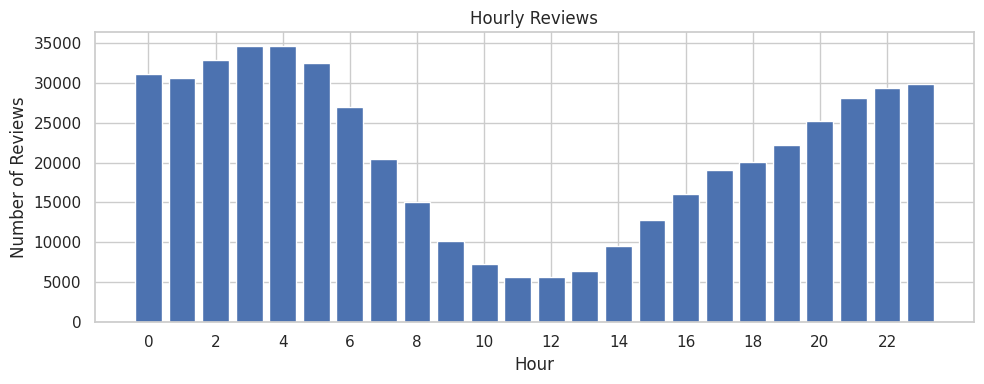

Unique businesses with morning review: 7382


/tmp/ipython-input-3021891356.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No morning review", "Has morning review"])


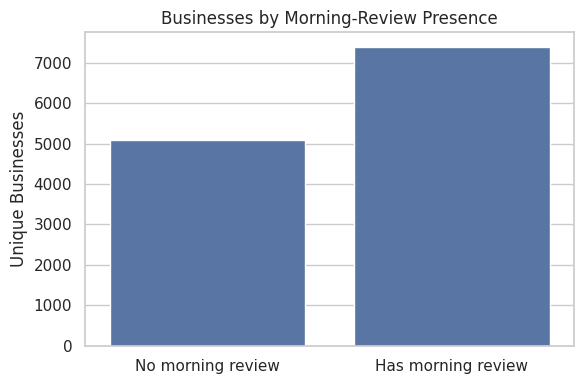

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

# keep only rows with a valid hour and gmap_id
rt = pd.to_numeric(df["review_time"], errors="coerce")
df_rt = df.loc[rt.notna() & df["gmap_id"].notna(), ["gmap_id"]].copy()
df_rt["review_time"] = rt[rt.notna()].astype(int)

# What time do people usually review?
hour_counts = df_rt["review_time"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Hourly Reviews")
plt.xlabel("Hour")
plt.ylabel("Number of Reviews")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

# How many businesses are reviewed in the morning time?
morning_mask = df_rt["review_time"].between(5, 12)
unique_morning_businesses = df_rt.loc[morning_mask, "gmap_id"].nunique()
print("Unique businesses with morning review:", unique_morning_businesses)

# build a per-business flag: does this business have any morning review?
biz_morning = (
    df_rt.assign(is_morning=morning_mask)
         .groupby("gmap_id", as_index=False)["is_morning"]
         .max()
)

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=biz_morning, x="is_morning")
ax.set_title("Businesses by Morning-Review Presence")
ax.set_xlabel("")
ax.set_xticklabels(["No morning review", "Has morning review"])
ax.set_ylabel("Unique Businesses")
plt.tight_layout()
plt.show()

